# Methodology Overview

This notebook walks through the methodology used to detect and characterize close approaches between satellites in Low Earth Orbit.

The goal here is to illustrate *how* the analysis works, not to reproduce the full 24-hour, 10,000-satellite run. For clarity and speed, small subsets of satellites and shorter time windows are used where appropriate.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from load_tle import read_tle_file
from propagate import make_time_grid, propagate_many


              name  satnum  incl_deg  mean_motion      epoch_jd  \
0          GENA-OT   66774   97.4392     0.066282  2.461061e+06   
1       SKYBEE-A01   62671   97.4123     0.066327  2.461061e+06   
2       UNICORN-2M   58726   97.5596     0.068348  2.461061e+06   
3       UNICORN-2L   58727   97.5574     0.066248  2.461061e+06   
4         NANOFF B   58755   97.5465     0.065932  2.461061e+06   
...            ...     ...       ...          ...           ...   
9882     CZ-2C R/B   54039   97.2951     0.067965  2.461061e+06   
9883      GSLV R/B   54149   87.3838     0.065292  2.461061e+06   
9884         XRISM   57800   31.0008     0.065923  2.461061e+06   
9885          ACS3   59588   97.2370     0.060532  2.461060e+06   
9886  SZ-21 MODULE   66515   41.4760     0.068281  2.461061e+06   

                                              satrec         a_km         e  \
0     <sgp4.wrapper.Satrec object at 0x7fd1d938d410>  6886.749269  0.000190   
1     <sgp4.wrapper.Satrec object at 

In [3]:
sat_df = read_tle_file("more_satellites.txt")

# Use a small subset for illustration
sat_df_small = sat_df.sample(50, random_state=42)

sat_df_small.head()


,name,satnum,incl_deg,mean_motion,epoch_jd,satrec,a_km,e,mean_alt_km,perigee_alt_km,apogee_alt_km
4463,STARLINK-30902,58421,42.9998,0.065561,2.461061e+06,<sgp4.wrapper.Satrec object at 0x7fd199888e10>,6937.187496,0.000051,559.050496,558.695312,559.405680
8128,STARLINK-34701,64953,97.6022,0.065698,2.461061e+06,<sgp4.wrapper.Satrec object at 0x7fd19a30ea10>,6927.563443,0.000186,549.426443,548.140687,550.712199
7292,STARLINK-33899,63799,43.0040,0.066654,2.461060e+06,<sgp4.wrapper.Satrec object at 0x7fd19a1d5210>,6861.119868,0.000106,482.982868,482.254903,483.710832
733,STARLINK-2159,47745,53.0874,0.066112,2.461062e+06,<sgp4.wrapper.Satrec object at 0x7fd1fa7a8810>,6898.588248,0.000131,520.451248,519.544773,521.357722
7632,STARLINK-34222,64191,53.1602,0.066765,2.461061e+06,<sgp4.wrapper.Satrec object at 0x7fd19a254a10>,6853.560410,0.000082,475.423410,474.859362,475.987458


We start by loading TLE data and selecting a small subset of satellites. The full analysis uses the same approach, but with more satellites loaded.


In [4]:
import datetime as dt

start = dt.datetime.utcnow().replace(minute=0, second=0, microsecond=0)
times = make_time_grid(start, hours=2, step_minutes=10)

traj_df = propagate_many(sat_df_small, times, sample_n=len(sat_df_small))
traj_df.head()


,time_utc,name,satnum,x_km,y_km,z_km,alt_km,sgp4_err
0,2026-01-29 22:00:00,STARLINK-30902,58421,4355.247347,3805.754480,3821.138068,553.893204,0
1,2026-01-29 22:10:00,STARLINK-30902,58421,1856.457107,6548.925386,1328.358299,557.235555,0
2,2026-01-29 22:20:00,STARLINK-30902,58421,-1413.495001,6572.082722,-1717.700217,560.215359,0
3,2026-01-29 22:30:00,STARLINK-30902,58421,-4097.636375,3869.010713,-4049.837877,561.679611,0
4,2026-01-29 22:40:00,STARLINK-30902,58421,-5086.196657,-435.810006,-4701.679967,561.972604,0


Satellite positions are propagated using the SGP4 model and sampled at fixed 10-minute intervals. This cadence is a compromise between temporal resolution and computational cost.


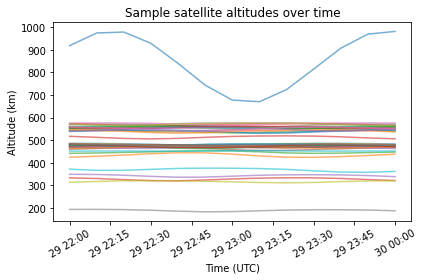

In [6]:
plt.figure()
for satnum, g in traj_df.groupby("satnum"):
    plt.plot(g["time_utc"], g["alt_km"], alpha=0.6)

plt.xlabel("Time (UTC)")
plt.ylabel("Altitude (km)")
plt.title("Sample satellite altitudes over time")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [9]:
from scipy.spatial import cKDTree

# Pick one timestep
t0 = traj_df["time_utc"].iloc[0]
g = traj_df[traj_df["time_utc"] == t0]

pos = g[["x_km", "y_km", "z_km"]].to_numpy()
tree = cKDTree(pos)

pairs = tree.query_pairs(r=10.0)
# print(len(pairs))


At each timestep, close approaches are detected using a KD-tree to efficiently find nearby satellite pairs. This avoids computing distances between all possible pairs.


Individual detections are aggregated across time to identify persistent encounters between the same satellite pairs. For each pair, we track:
- the minimum sampled separation
- the number of detection timesteps
- the total duration of the encounter


The full analysis applies this same methodology to ~10,000 satellites over a 24-hour window. Results are stored as intermediate parquet files and summarized into a per-pair table that captures both proximity and persistence.
